# Computer Vision Homework | MNIST

### Importing Necessary Packages

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import layers, models

### Importing Data

In [3]:
sample_submission = pd.read_csv('data/mnist/sample_submission.csv')
test = pd.read_csv('data/mnist/test.csv')
train = pd.read_csv('data/mnist/train.csv')

### Data Formatting

In [50]:
# extract the labels
labels = train.iloc[:, 0].values
# extract the features
features = train.iloc[:, 1:].values

#reshape each row to 28x28
features = features.reshape(features.shape[0], 28, 28)


### Initial Analysis

In [44]:
#small analysis of dataset
print(f"The train dataset containes {features.shape[0]} images.")
print(f"Each image has a size of {features.shape[1]}x{features.shape[2]}.\n")

print(f"The labels array has {labels.shape[0]} rows.\n")

print(f"The test dataset has {test.shape[0]} rows and {test.shape[1]} columns.")
print("That means it has 28000 images with 784 pixels each, the first column \
however it does not contain the labels.\n")

The train dataset containes 42000 images.
Each image has a size of 28x28.

The labels array has 42000 rows.

The test dataset has 28000 rows and 784 columns.
That means it has 28000 images with 784 pixels each, the first column however it does not contain the labels.



This is how a single image looks like:


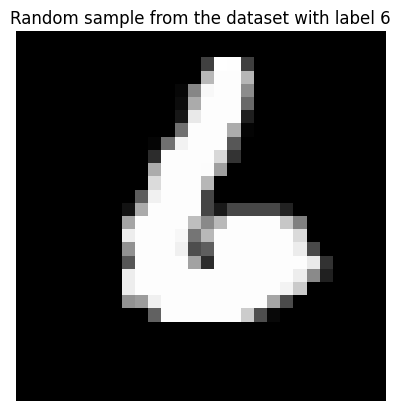

In [48]:
print("This is how a single image looks like:")
random_ind = random.randint(1,42000)
random_sample = features[random_ind]
label = labels[random_ind]
random_sample = random_sample.reshape((28, 28))

plt.imshow(random_sample, cmap='gray')
plt.axis('off')
plt.title(f"Random sample from the dataset with label {label}")
plt.show()

The number of samples per label is:
[4132 4684 4177 4351 4072 3795 4137 4401 4063 4188]


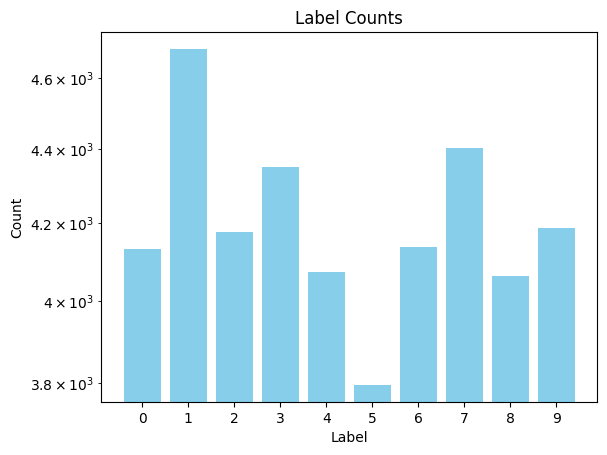

In [75]:
label_counts = np.unique(labels, return_counts=True)
print("The number of samples per label is:")
print(label_counts[1]) 

plt.bar(label_counts[0], label_counts[1], color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.xticks(ticks=np.arange(10))
plt.yscale('log')
plt.show()

### Preprocessing

In [134]:
def preprocessing(features, labels):
    #expects grayscale images
    num_samples, image_rows, image_columns = features.shape
    # convert to float
    features = features.astype('float32')
    
    # reshape to 1 channel
    features = features.reshape(num_samples, image_rows, image_columns, 1)
    
    X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Split the temporary set into validation and test sets
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)
    X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    #scaling
    scaler = StandardScaler()
    X_train = X_train.reshape((X_train.shape[0], image_rows * image_columns))
    X_validation = X_validation.reshape((X_validation.shape[0], image_rows * image_columns))
    X_test = X_test.reshape((X_test.shape[0], image_rows * image_columns))
    
    X_train = scaler.fit_transform(X_train)
    X_validation= scaler.transform(X_validation)
    X_test = scaler.transform(X_test)
    
    X_train = X_train.reshape((X_train.shape[0], image_rows, image_columns, 1))
    X_validation = X_validation.reshape((X_validation.shape[0], image_rows, image_columns, 1))
    X_test = X_test.reshape((X_test.shape[0], image_rows, image_columns, 1))

    return X_train, X_test, X_validation, y_train, y_test, y_validation

### Baseline Model

In [135]:
def baseline_model(X_train, X_test, X_validation, y_train, y_test, y_validation):
    dummy_classifier = DummyClassifier(strategy="most_frequent") #using "most frequent" strategy
    dummy_classifier.fit(X_train, y_train)

    y_val_pred = dummy_classifier.predict(X_validation)
    val_accuracy = accuracy_score(y_validation, y_val_pred)
    print(f"Accuracy on validation set: {val_accuracy:.4f}")
    
    y_pred = dummy_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test set: {accuracy:.4f}")

### Linear Model

In [143]:
def linear_model(X_train, X_test, X_validation, y_train, y_test, y_validation):
    num_samples, num_channels, height, width = X_train.shape
    X_train_flattened = X_train.reshape((num_samples, num_channels * height * width))
    num_samples_test, _, _, _ = X_test.shape
    X_test_flattened = X_test.reshape((num_samples_test, num_channels * height * width))
    X_validation_flattened = X_validation.reshape((X_validation.shape[0], num_channels * height * width))   
    
    logistic_regression = LogisticRegression(max_iter=1000, C=1)
    logistic_regression.fit(X_train_flattened, y_train)
    
    # Evaluate on the Validation Set
    y_val_pred = logistic_regression.predict(X_validation_flattened)
    val_accuracy = accuracy_score(y_validation, y_val_pred)
    print(f"Accuracy on validation set: {val_accuracy:.4f}")

    # Evaluate on the Test Set
    y_test_pred = logistic_regression.predict(X_test_flattened)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy on test set: {test_accuracy:.4f}")

### CNN

In [4]:
def cnn(X_train, X_test, X_validation, y_train, y_test, y_validation, num_classes):
    #print(X_train[0])
    # Create a simple CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with 10 classes

    # Compile the model
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=5, validation_data=(X_validation, y_validation))
    
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    #evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

### Pipeline

In [141]:
def pipeline(features, labels, num_classes):
    X_train, X_test, X_validation, y_train, y_test, y_validation = preprocessing(features, labels)
    print("-------------------")
    print("Baseline model:")
    baseline_model(X_train, X_test, X_validation, y_train, y_test, y_validation)
    print("-------------------")
    print("Linear model:")
    linear_model(X_train, X_test, X_validation, y_train, y_test, y_validation)
    print("-------------------")
    print("CNN model:")
    cnn(X_train, X_test, X_validation, y_train, y_test, y_validation, num_classes=num_classes)
    print("-------------------")

-------------------
Baseline model:
Accuracy on validation set: 0.1083
Accuracy on test set: 0.1081
-------------------
Linear model:
Accuracy on validation set: 0.8983
Accuracy on test set: 0.8990
-------------------
CNN model:
Epoch 1/5
788/788 [==============================] - 19s 23ms/step - loss: 0.2106 - accuracy: 0.9355 - val_loss: 0.0719 - val_accuracy: 0.9771
Epoch 2/5
788/788 [==============================] - 18s 23ms/step - loss: 0.0616 - accuracy: 0.9808 - val_loss: 0.0757 - val_accuracy: 0.9767
Epoch 3/5
788/788 [==============================] - 18s 23ms/step - loss: 0.0456 - accuracy: 0.9857 - val_loss: 0.0535 - val_accuracy: 0.9810
Epoch 4/5
788/788 [==============================] - 14s 18ms/step - loss: 0.0321 - accuracy: 0.9900 - val_loss: 0.0682 - val_accuracy: 0.9798
Epoch 5/5
788/788 [==============================] - 13s 17ms/step - loss: 0.0240 - accuracy: 0.9917 - val_loss: 0.0404 - val_accuracy: 0.9871


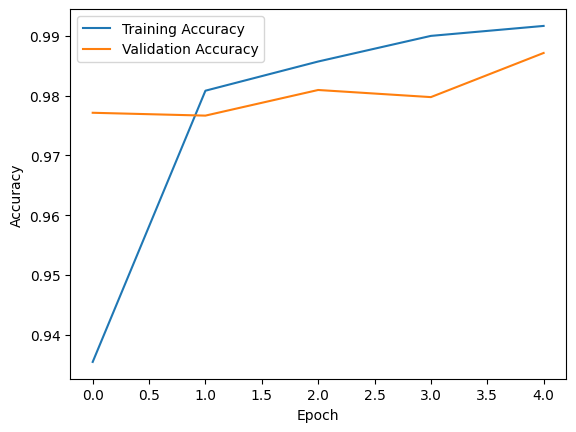

132/132 [==============================] - 1s 5ms/step - loss: 0.0384 - accuracy: 0.9869
Test Loss: 0.0384
Test Accuracy: 0.9869
-------------------


In [145]:
pipeline(features, labels, 10)